# LAB 7: Neural networks

The purpose of this lab work is to study the training and optimisaton of feed-forward neural networks in Keras. Overfitting is prevented with early stopping regularisation (as seen for linear models), but other regularisation methods inspired from Lasso, Ridge, Elastic net linear algos that we studied so far, will be introduced in the next sessions.  

## Tasks 
1. Study and run (cell by cell) the code below which illustrates the training and evaluation, and also optimisation of neural networks.  

2. By applying what learned in the previous lab 3 for data preparation/transformation, start preparing your coursework dataset, and then experiment with building a neural network model with a given architecture (choosing manually the number of hidden layers, number of neurons in each layer, the activation functions, the learning rate, the optimniser) following what learned in this lab handout. Save your model in a file. 

3. Extend Task 2 by tuning the model hyperparameters.

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

'''
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

'''
    
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


2024-02-25 11:47:29.728795: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-25 11:47:29.749154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Perceptrons

In [2]:
# Fitting a perceptron on Iris dataset, as done for logistic regression.
# We have 2 classes: 0 (Iris Setosa) and 1 (Not-Iris Setosa).

import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # 
y = (iris.target == 0).astype(np.int8)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

# make a prediction for the plant having these sizes: petal length, petal width
y_pred = per_clf.predict([[2, 0.5]])

In [3]:
# We can see it's Setosa (class 1)
y_pred

array([1], dtype=int8)

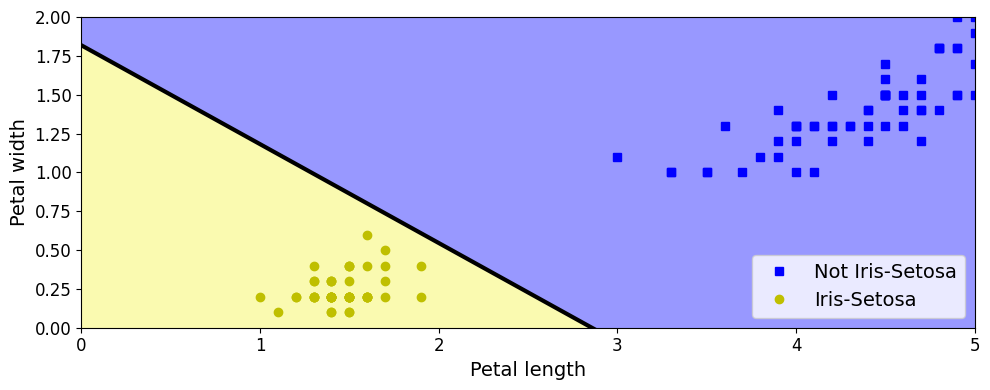

In [4]:

# This is just o represent the predictions with this model and the separation line

a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [5]:
# Defining and plotting some of the most common actvation functions 

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

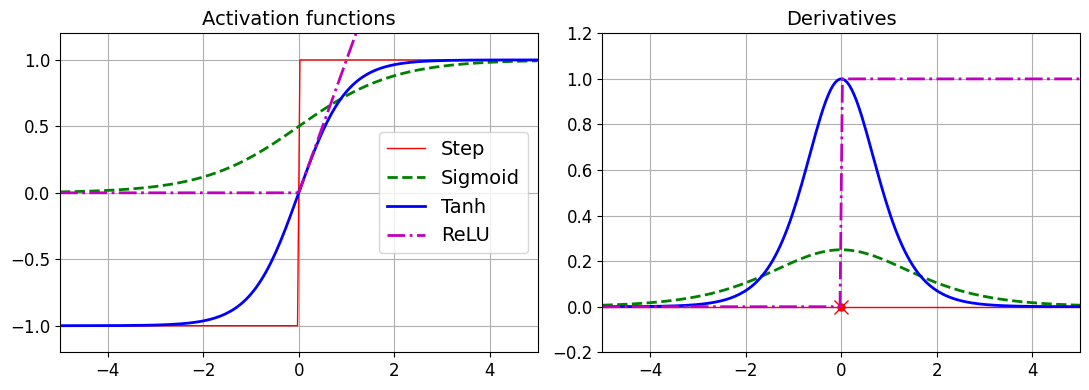

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

# Building an Image Classifier using Fashion MNIST dataset

First let's import TensorFlow and Keras.

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
tf.__version__

'2.13.1'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [9]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [10]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [11]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [12]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

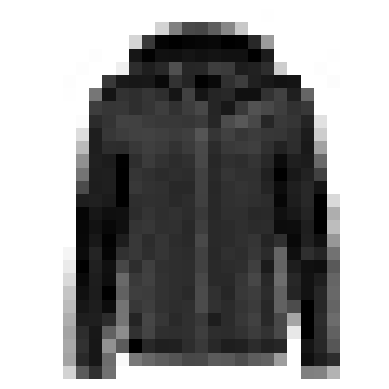

In [13]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [14]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [15]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [16]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [17]:
X_valid.shape

(5000, 28, 28)

In [18]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

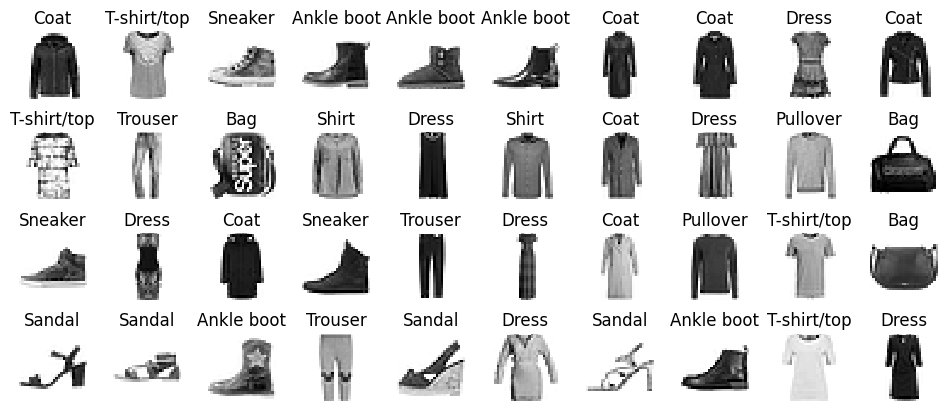

In [19]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [20]:
# Define a nerual net with Sequential API 

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

2024-02-25 11:47:33.074212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22287 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [21]:
# Clear session

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [23]:
model.layers

In [24]:
# Let's check the model's details and graphcal representation
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
# Layers have names

hidden1 = model.layers[1]
hidden1.name

'dense'

In [27]:
model.get_layer(hidden1.name) is hidden1

True

In [28]:
# Let's get the weights of hidden 1 layer (of connections entering the layer)
# Notice these wights are initialised with random numbers .
# When we fit the model to the data, these weights will be updated step by step with Gradient Descent

weights, biases = hidden1.get_weights()

In [29]:
weights

array([[ 0.05042785, -0.0231879 , -0.05864502, ..., -0.04969501,
        -0.05811425,  0.04486237],
       [-0.00483811, -0.04804679,  0.05320281, ..., -0.01640427,
         0.0092072 ,  0.03210862],
       [ 0.03773762,  0.02344377,  0.02673139, ...,  0.04075776,
         0.04606104,  0.05901404],
       ...,
       [ 0.02372692,  0.001403  , -0.05422324, ...,  0.05006257,
        -0.05617103,  0.02847722],
       [ 0.00609791, -0.04066172, -0.05960449, ...,  0.00770414,
        -0.02311654, -0.04526883],
       [ 0.06407467, -0.04575948,  0.03111259, ...,  0.05600797,
        -0.02504159, -0.02542358]], dtype=float32)

In [30]:
# there are 784 x 300 weights

weights.shape

(784, 300)

In [31]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [32]:
# and 300 biases

biases.shape

(300,)

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [34]:
# Now fit the model in 30 epochs

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30


2024-02-25 11:47:34.628988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-25 11:47:34.643825: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcfe804d0a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-25 11:47:34.643840: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-02-25 11:47:34.658905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-02-25 11:47:34.694118: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 [==============================] - 2s 869us/step - loss: 0.7311 - accuracy: 0.7613 - val_loss: 0.5257 - val_accuracy: 0.8198
Epoch 2/30
1719/1719 [==============================] - 1s 808us/step - loss: 0.4905 - accuracy: 0.8275 - val_loss: 0.4400 - val_accuracy: 0.8522
Epoch 3/30
1719/1719 [==============================] - 1s 856us/step - loss: 0.4446 - accuracy: 0.8437 - val_loss: 0.5171 - val_accuracy: 0.8084
Epoch 4/30
1719/1719 [==============================] - 1s 871us/step - loss: 0.4177 - accuracy: 0.8530 - val_loss: 0.3982 - val_accuracy: 0.8670
Epoch 5/30
1719/1719 [==============================] - 1s 871us/step - loss: 0.3991 - accuracy: 0.8602 - val_loss: 0.3808 - val_accuracy: 0.8678
Epoch 6/30
1719/1719 [==============================] - 1s 858us/step - loss: 0.3808 - accuracy: 0.8652 - val_loss: 0.3753 - val_accuracy: 0.8734
Epoch 7/30
1719/1719 [==============================] - 1s 804us/step - loss: 0.3683 - accuracy: 0.8704 - val_loss: 0.3682 - val_accura

In [35]:
# parameters of the training

history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [36]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [37]:
# history is a dictionary containing performance vectors with their names as keys

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

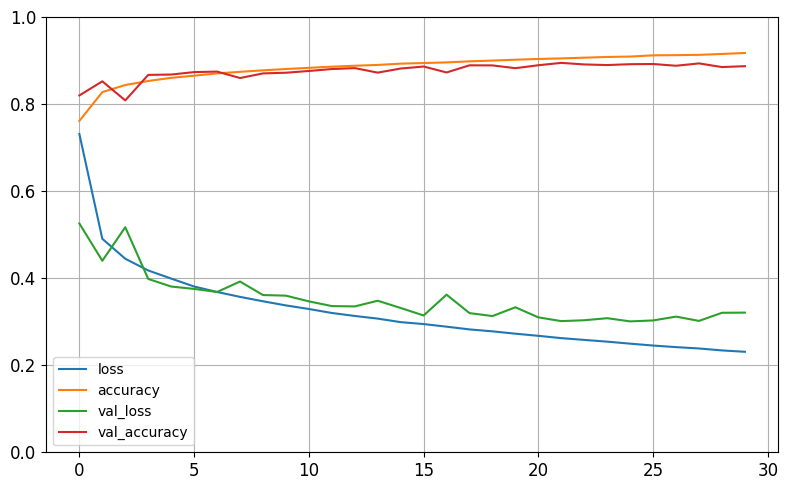

In [38]:
# Let's plot the learning curves

import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [39]:
# Evaluate the model on the test set

model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 551us/step - loss: 0.3568 - accuracy: 0.8743


[0.35675573348999023, 0.8743000030517578]

In [40]:
# Make predictions on 3 instances.
# Observe each row provides the 10 probabilities for the 10 classes (they add up to 1).
# 1st row shows that the class 9 last one) has highest probability 96%, so that's the predicted class.

X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 28ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.06, 0.  , 0.92],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

**Warning**: `model.predict_classes(X_new)` is deprecated. It is replaced with `np.argmax(model.predict(X_new), axis=-1)`.

In [41]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 7ms/step


array([9, 2, 1])

In [42]:
# Get the class names for those predictions 

np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [43]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

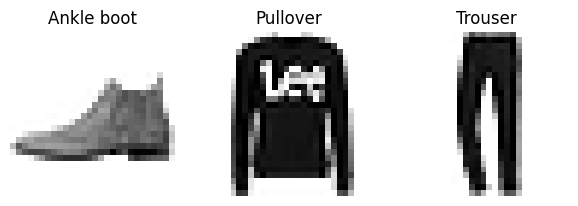

In [44]:
# Let's disply the 3 instances.
# We see that indeed, what we predicted as classes ('Ankle boot', 'Pullover', 'Trouser'), 
# are correct.

plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [45]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

In [47]:
# Let's define and fit a regression neural net model with 1 hidden layer of 30 neurons 
# in which we use the ReLU function. We use Stochastic Gradient Descent (SGD) for 20 epochs,
# with a learning rate = 0.001

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 890us/step - loss: 2.4715 - val_loss: 1.4128
Epoch 2/20
363/363 [==============================] - 0s 774us/step - loss: 0.8282 - val_loss: 0.6884
Epoch 3/20
363/363 [==============================] - 0s 816us/step - loss: 0.6665 - val_loss: 0.6080
Epoch 4/20
363/363 [==============================] - 0s 817us/step - loss: 0.6113 - val_loss: 0.5723
Epoch 5/20
363/363 [==============================] - 0s 861us/step - loss: 0.5761 - val_loss: 0.5652
Epoch 6/20
363/363 [==============================] - 0s 843us/step - loss: 0.5503 - val_loss: 0.5172
Epoch 7/20
363/363 [==============================] - 0s 805us/step - loss: 0.5298 - val_loss: 0.5000
Epoch 8/20
363/363 [==============================] - 0s 855us/step - loss: 0.5130 - val_loss: 0.5134
Epoch 9/20
363/363 [==============================] - 0s 853us/step - loss: 0.4983 - val_loss: 0.4935
Epoch 10/20
363/363 [==============================] - 0s 805us/step - loss: 0.485

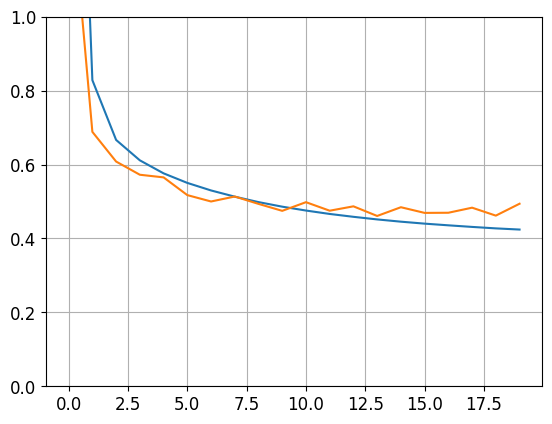

In [48]:
# Plot the learning curves

plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [49]:
y_pred

array([[0.46589297],
       [1.666244  ],
       [3.3508542 ]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

In [51]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 30)                   270       ['input_1[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 30)                   930       ['dense_5[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 38)                   0         ['input_1[0][0]',             
                                                                     'dense_6[0][0]']         

In [53]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.7032 - val_loss: 3.5860
Epoch 2/20
363/363 [==============================] - 0s 905us/step - loss: 0.8282 - val_loss: 0.7543
Epoch 3/20
363/363 [==============================] - 0s 870us/step - loss: 0.7269 - val_loss: 0.8773
Epoch 4/20
363/363 [==============================] - 0s 891us/step - loss: 0.6838 - val_loss: 0.8262
Epoch 5/20
363/363 [==============================] - 0s 907us/step - loss: 0.6440 - val_loss: 0.6051
Epoch 6/20
363/363 [==============================] - 0s 943us/step - loss: 0.6089 - val_loss: 0.5808
Epoch 7/20
363/363 [==============================] - 0s 905us/step - loss: 0.5852 - val_loss: 0.5591
Epoch 8/20
363/363 [==============================] - 0s 894us/step - loss: 0.5628 - val_loss: 0.6687
Epoch 9/20
363/363 [==============================] - 0s 897us/step - loss: 0.5400 - val_loss: 0.5243
Epoch 10/20
363/363 [==============================] - 0s 880us/step - loss: 0.5232 

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

In [55]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [56]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 2.0414 - val_loss: 0.8731
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7376 - val_loss: 0.7319
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6340 - val_loss: 0.6517
Epoch 4/20
363/363 [==============================] - 0s 959us/step - loss: 0.5884 - val_loss: 0.5797
Epoch 5/20
363/363 [==============================] - 0s 941us/step - loss: 0.5587 - val_loss: 0.5404
Epoch 6/20
363/363 [==============================] - 0s 968us/step - loss: 0.5340 - val_loss: 0.5162
Epoch 7/20
363/363 [==============================] - 0s 956us/step - loss: 0.5159 - val_loss: 0.5062
Epoch 8/20
363/363 [==============================] - 0s 898us/step - loss: 0.5002 - val_loss: 0.4852
Epoch 9/20
363/363 [==============================] - 0s 871us/step - loss: 0.4868 - val_loss: 0.4666
Epoch 10/20
363/363 [==============================] - 0s 913us/step - loss: 0.4764 - va

Adding an auxiliary output for regularization:

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

In [58]:
# Define a model with the Functional API.
# Notice the model has 1 main output, and 1 auxiliary output, couting to total loss with .9 and .1 weights.
# The loss function is MSE for both output nodes.
# Notice agan the optimizer used to update (improve iteratively) the model is SGD, with 
# constant learning rate 0.001.
# Auxiliary output here may help making sure that part of the model learn and capture pattern from data. 

input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [59]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [60]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 2.1559 - main_output_loss: 1.8985 - aux_output_loss: 4.4733 - val_loss: 1.4587 - val_main_output_loss: 1.0297 - val_aux_output_loss: 5.3194
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.8252 - main_output_loss: 0.6257 - aux_output_loss: 2.6209 - val_loss: 0.9930 - val_main_output_loss: 0.5626 - val_aux_output_loss: 4.8660
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6729 - main_output_loss: 0.5451 - aux_output_loss: 1.8236 - val_loss: 0.9454 - val_main_output_loss: 0.5281 - val_aux_output_loss: 4.7016
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6121 - main_output_loss: 0.5138 - aux_output_loss: 1.4961 - val_loss: 0.8612 - val_main_output_loss: 0.4866 - val_aux_output_loss: 4.2326
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5775 - main_output_loss: 0.4935 - aux_output_loss: 1.3334 - val_loss

In [61]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

1/1 [==============================] - 0s 22ms/step


# Saving and Restoring models

In [62]:
np.random.seed(42)
tf.random.set_seed(42)

In [63]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [64]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.5615 - val_loss: 2.2238
Epoch 2/10
363/363 [==============================] - 0s 937us/step - loss: 0.7424 - val_loss: 0.8649
Epoch 3/10
363/363 [==============================] - 0s 922us/step - loss: 0.6675 - val_loss: 0.7343
Epoch 4/10
363/363 [==============================] - 0s 925us/step - loss: 0.6209 - val_loss: 0.5986
Epoch 5/10
363/363 [==============================] - 0s 912us/step - loss: 0.5833 - val_loss: 0.5497
Epoch 6/10
363/363 [==============================] - 0s 897us/step - loss: 0.5503 - val_loss: 0.5247
Epoch 7/10
363/363 [==============================] - 0s 917us/step - loss: 0.5237 - val_loss: 0.5076
Epoch 8/10
363/363 [==============================] - 0s 925us/step - loss: 0.5021 - val_loss: 0.4685
Epoch 9/10
363/363 [==============================] - 0s 921us/step - loss: 0.4830 - val_loss: 0.4536
Epoch 10/10
162/162 [==============================] - 0s 438us/step - loss: 0.4522


In [65]:
# Save the trained model in this file in HDF5 format (here extension .h5)

model.save("my_keras_model.h5")

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [66]:
# Retrieve model from file

model = keras.models.load_model("my_keras_model.h5")

In [67]:
model.predict(X_new)

1/1 [==============================] - 0s 21ms/step


array([[0.81211257],
       [1.405019  ],
       [2.9539392 ]], dtype=float32)

In [68]:
# Saving model's weights

model.save_weights("my_keras_weights.ckpt")

In [69]:
# Loading model's weights

model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

Callbacks are useful for multiple things, but mainly for early stopping to prevent overfitting of the model. 

In [70]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [71]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [72]:
# We define a callback which will save the best model so far on the validation set, in a file my_keras_model.h5.
# Once the number of iterations is finished, we can roll back the model to the best one found.

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.8191 - val_loss: 1.4599
Epoch 2/10
363/363 [==============================] - 0s 926us/step - loss: 0.7420 - val_loss: 0.6771
Epoch 3/10
363/363 [==============================] - 0s 944us/step - loss: 0.6303 - val_loss: 0.5805
Epoch 4/10
363/363 [==============================] - 0s 909us/step - loss: 0.5708 - val_loss: 0.5918
Epoch 5/10
363/363 [==============================] - 0s 896us/step - loss: 0.5311 - val_loss: 0.5344
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5006 - val_loss: 0.5526
Epoch 7/10
363/363 [==============================] - 0s 930us/step - loss: 0.4779 - val_loss: 0.5000
Epoch 8/10
363/363 [==============================] - 0s 944us/step - loss: 0.4599 - val_loss: 0.4542
Epoch 9/10
363/363 [==============================] - 0s 931us/step - loss: 0.4462 - val_loss: 0.4750
Epoch 10/10
162/162 [==============================] - 0s 479us/step - loss: 0.4403


In [73]:

# Here we use another callback - for early stopping. 
# This will make the training stop if the loss doesn't significantly 
# improve for 10 epochs (see patience=10)

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4462 - val_loss: 0.4818
Epoch 2/100
363/363 [==============================] - 0s 886us/step - loss: 0.4352 - val_loss: 0.5570
Epoch 3/100
363/363 [==============================] - 0s 928us/step - loss: 0.4270 - val_loss: 0.5252
Epoch 4/100
363/363 [==============================] - 0s 936us/step - loss: 0.4201 - val_loss: 0.4703
Epoch 5/100
363/363 [==============================] - 0s 936us/step - loss: 0.4148 - val_loss: 0.4249
Epoch 6/100
363/363 [==============================] - 0s 928us/step - loss: 0.4094 - val_loss: 0.5536
Epoch 7/100
363/363 [==============================] - 0s 908us/step - loss: 0.4061 - val_loss: 0.4756
Epoch 8/100
363/363 [==============================] - 0s 876us/step - loss: 0.4022 - val_loss: 0.3880
Epoch 9/100
363/363 [==============================] - 0s 877us/step - loss: 0.3988 - val_loss: 0.4611
Epoch 10/100
363/363 [==============================] - 0s 879us/step - los

In [74]:
# You can customize your own callbacks as ilustrated here. 
# The new callback prints the ratio between the validation loss and training loss.
# When this ratio starts to increase significantly over 1, it is a sign that the mdoel overfits,
# because the training loss is significantly smaller than validaton loss.  

class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [75]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

343/363 [===========================>..] - ETA: 0s - loss: 0.3875
val/train: 1.19
363/363 [==============================] - 0s 913us/step - loss: 0.3906 - val_loss: 0.4654


# TensorBoard 


We now set the TensorBoard, which is a useful tool to monitor the model training and performance. It works by storing the details of the processing in log files in a specially created folder, and using those log files to display charts about the model training/ tuning. 

In [76]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [77]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2024_02_25-11_49_03'

In [78]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [79]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [80]:
# We use a TensorBoard callback to store details on performances of the model during its tuning

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 1.6472 - val_loss: 0.8871
Epoch 2/30
363/363 [==============================] - 0s 953us/step - loss: 0.7274 - val_loss: 0.6524
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6535 - val_loss: 0.6192
Epoch 4/30
363/363 [==============================] - 0s 995us/step - loss: 0.6091 - val_loss: 0.5617
Epoch 5/30
363/363 [==============================] - 0s 984us/step - loss: 0.5744 - val_loss: 0.5293
Epoch 6/30
363/363 [==============================] - 0s 996us/step - loss: 0.5445 - val_loss: 0.5051
Epoch 7/30
363/363 [==============================] - 0s 991us/step - loss: 0.5201 - val_loss: 0.4868
Epoch 8/30
363/363 [==============================] - 0s 998us/step - loss: 0.4994 - val_loss: 0.4637
Epoch 9/30
363/363 [==============================] - 0s 979us/step - loss: 0.4815 - val_loss: 0.4496
Epoch 10/30
363/363 [==============================] - 0s 951us/step - loss: 0.4663 - 

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [81]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [82]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2024_02_25-11_49_16'

In [83]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [84]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [85]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 0.5143 - val_loss: 0.4031
Epoch 2/30
363/363 [==============================] - 0s 952us/step - loss: 0.3994 - val_loss: 0.3811
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3801 - val_loss: 0.4499
Epoch 4/30
363/363 [==============================] - 0s 999us/step - loss: 0.3677 - val_loss: 0.3480
Epoch 5/30
186/363 [==============>...............] - ETA: 0s - loss: 0.3555

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


363/363 [==============================] - 0s 1ms/step - loss: 0.3579 - val_loss: 0.3373
Epoch 6/30
363/363 [==============================] - 0s 929us/step - loss: 0.3540 - val_loss: 0.6301
Epoch 7/30
363/363 [==============================] - 0s 932us/step - loss: 0.3619 - val_loss: 0.4869
Epoch 8/30
363/363 [==============================] - 0s 918us/step - loss: 0.3440 - val_loss: 0.3738
Epoch 9/30
363/363 [==============================] - 0s 909us/step - loss: 0.3488 - val_loss: 0.8902
Epoch 10/30
363/363 [==============================] - 0s 943us/step - loss: 0.3458 - val_loss: 0.4997
Epoch 11/30
363/363 [==============================] - 0s 925us/step - loss: 0.3353 - val_loss: 0.8031
Epoch 12/30
363/363 [==============================] - 0s 907us/step - loss: 0.3320 - val_loss: 1.0671
Epoch 13/30
363/363 [==============================] - 0s 939us/step - loss: 0.3321 - val_loss: 0.3024
Epoch 14/30
363/363 [==============================] - 0s 904us/step - loss: 0.3196 - val_l

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [86]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module keras.src.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

## Fine-Tuning Neural Network Hyperparameters with keras-tuner library using 3 methods: Random Search, Hyperband and Bayesian optimisations

In [87]:
# using fashin_mnist data

import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [88]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [89]:
# install keras_tuner library if not already installed 
    
%pip install -q -U keras_tuner


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [90]:
# define function that builds a neural net model and a hyperparameter search space

import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

### Fine-tune neural net model using Random Search optimisation

In [91]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 18s]
val_accuracy: 0.8424000144004822

Best val_accuracy So Far: 0.8636000156402588
Total elapsed time: 00h 01m 37s


In [92]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [93]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print('test_accuracy is', test_accuracy)

313/313 [==============================] - 0s 686us/step - loss: 0.4028 - accuracy: 0.8578
test_accuracy is 0.8578000068664551


In [94]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 8,
 'n_neurons': 37,
 'learning_rate': 0.008547485565344062,
 'optimizer': 'sgd'}

In [95]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 3 summary
Hyperparameters:
n_hidden: 8
n_neurons: 37
learning_rate: 0.008547485565344062
optimizer: sgd
Score: 0.8636000156402588


In [96]:
best_trial.metrics.get_last_value("val_accuracy")

0.8636000156402588

In [97]:
# Use HyperModel, adding data normalisation as option

class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

### Fine-tune neural net model using Hyperband optimisation

In [98]:
# See https://keras.io/api/keras_tuner/tuners/hyperband/ or more details on this optimisation library 

hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [99]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 21s]
val_accuracy: 0.8226000070571899

Best val_accuracy So Far: 0.8784000277519226
Total elapsed time: 00h 08m 33s


In [100]:
top3_models = hyperband_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [101]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print('test_accuracy is', test_accuracy)

313/313 [==============================] - 0s 667us/step - loss: 0.3427 - accuracy: 0.8771
test_accuracy is 0.8770999908447266


In [102]:
top3_params = hyperband_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 247,
 'learning_rate': 0.0003987720809096887,
 'optimizer': 'adam',
 'normalize': True,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0049'}

In [103]:
best_trial = hyperband_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 0054 summary
Hyperparameters:
n_hidden: 7
n_neurons: 247
learning_rate: 0.0003987720809096887
optimizer: adam
normalize: True
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0049
Score: 0.8784000277519226


In [104]:
best_trial.metrics.get_last_value("val_accuracy")

0.8784000277519226

### Fine-tune neural net model using Bayesian optimisation

In [105]:
# see https://towardsdatascience.com/bayesian-optimization-concept-explained-in-layman-terms-1d2bcdeaf12f
# see https://keras.io/api/keras_tuner/tuners/bayesian/ for more details on Bayesian optimisation params

bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 21s]
val_accuracy: 0.8468000292778015

Best val_accuracy So Far: 0.8586000204086304
Total elapsed time: 00h 02m 27s


In [106]:
top3_models = bayesian_opt_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [107]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print('test_accuracy is', test_accuracy)

313/313 [==============================] - 0s 612us/step - loss: 0.4381 - accuracy: 0.8478
test_accuracy is 0.8478000164031982


In [108]:
top3_params = bayesian_opt_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 4,
 'n_neurons': 239,
 'learning_rate': 0.0007767449713530701,
 'optimizer': 'sgd',
 'normalize': False}

In [109]:
best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 04 summary
Hyperparameters:
n_hidden: 4
n_neurons: 239
learning_rate: 0.0007767449713530701
optimizer: sgd
normalize: False
Score: 0.8586000204086304


In [110]:
best_trial.metrics.get_last_value("val_accuracy")

0.8586000204086304

In [111]:
# %tensorboard --logdir {root_logdir}